In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from scipy.special import softmax
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [79]:
Xtrain, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
ytrain = np.asarray([int(numeric_string) for numeric_string in y])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Split the data to training, testing, and validation subsets

In [80]:
# loading the temporary variables for fast retrieval
#with open('temp.pickle', 'rb') as handle:
    #Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
    
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

print("N_sample: ", Nsamples)
print("N_feature: ",Nfeatures)

print("X_test_shape :",X_test.shape)
print("X_shape :",X_train.shape)




N_sample:  49000
N_feature:  784
X_test_shape : (14000, 784)
X_shape : (49000, 784)


* The sample aftersplit is as follow: 
- Train set has 49000 samples with 784 features
- Test set has 14000 samples with 784 features
- Val set has 7000 samples with 784 features


# Accuracy of a classifier

In [81]:
def testLinearMCClassifier(A,X_test, y_test):
    # Add a column of ones to X_test for the bias term
    X_test_augmented = np.column_stack((X_test, np.ones(X_test.shape[0])))
    #print(X_test_augmented.shape)
    class_scores = np.dot(X_test_augmented, A)

    #print(A.shape)
    # Predicted class is the one with the highest score
    predictions = np.argmax(class_scores, axis=1)
    #print(predictions.shape)
    # Count how many predictions are incorrect
    misclassified = np.sum(predictions != y_test)

    return misclassified


## Define gaussianMultiChannelClassifier to perform multi-class Gaussian classifier 

Mis-classifications= 9307 out of  49000  equivalent to  18.993877551020407%
Mis-classifications= 1337 out of  7000  equivalent to  19.1%
Mis-classifications= 2634 out of  14000  equivalent to  18.814285714285713%


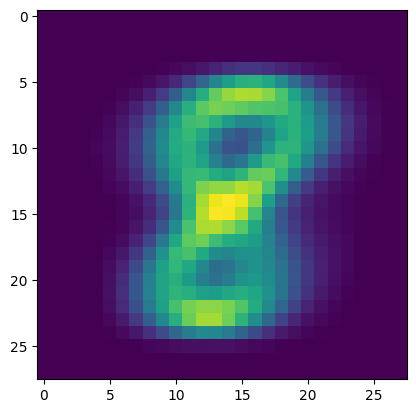

In [82]:
#------TRAINING CODE --------------

def gaussianMultiChannelClassifier(Xtrain,ytrain):
    
    n_classes = len(np.unique(y_train))
    n_features = X_train.shape[1]
    #print("mu2:", mu2)
    A1 = np.zeros((n_features + 1, n_classes))

    for i in range(n_classes):
        mu_i = np.mean(X_train[y_train == i], axis=0)
        A1[:-1, i] = mu_i
        A1[-1, i] = -0.5 * np.dot(mu_i.T, mu_i)
    #print(A1.shape)
    return A1
    #YOUR CODE HERE


a = gaussianMultiChannelClassifier(X_train,y_train)
plt.imshow(np.reshape(a[0:-1,8],(28,28)))


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
train = testLinearMCClassifier(a,X_train,y_train)
val = testLinearMCClassifier(a,X_val,y_val)
test = testLinearMCClassifier(a,X_test,y_test)

print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train *100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))


## Define logisticRegressionMultiClassClassifier

You may choose the step size as 1e-4. You can try changing it.

Mis-classifications= 6052 out of  49000  equivalent to  12.351020408163265%
Mis-classifications= 896 out of  7000  equivalent to  12.8%
Mis-classifications= 1808 out of  14000  equivalent to  12.914285714285715%


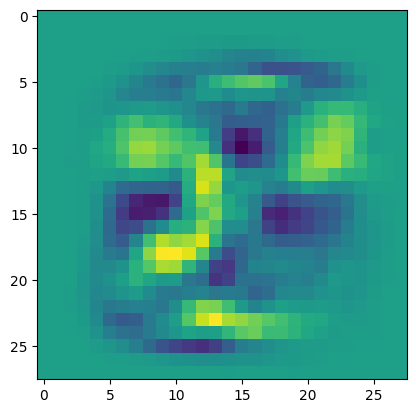

In [83]:
def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)  # For numerical stability
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def logisticRegressionMultiClassClassifier(Xtrain, ytrain, iterations=100, step_size=1e-4, verbose=True):
    n_classes = len(np.unique(ytrain))
    n_features = Xtrain.shape[1]
    A2 = np.zeros((n_features + 1, n_classes))  # Matrix to store weights for each class

    Xtrain_transformed = np.column_stack((Xtrain, np.ones((Xtrain.shape[0], 1))))  # Add bias term

    for class_index in range(n_classes):
        # Initialize weights for this class
        ytrain_binary = (ytrain == class_index).astype(int)  # Binary labels for one-vs-rest
        #print("Y train shape: ", ytrain_binary.shape )
        #a = np.zeros(n_features + 1)

        for i in range(iterations):
           scores = np.dot(Xtrain_transformed, A2)
           predictions = softmax(scores)
           #print("prediction shape: ", predictions.shape )
           prob_vector = predictions[:, class_index]
           gradient = -np.dot(Xtrain_transformed.T[:-1], (prob_vector - ytrain_binary))
           bias_gradient = np.sum(prob_vector - ytrain_binary)
           #bias_gradient = -np.sum(ytrain_binary - prob_vector)
           # Update weights and bias separately
           A2[:-1, class_index] += step_size * gradient
           A2[-1, class_index] += step_size * bias_gradient  
           epsilon = 1e-6
           if verbose and i % 50 == 0:
                cost = -np.mean(ytrain_binary * np.log(prob_vector+epsilon) + (1 - ytrain_binary) * np.log(1 - prob_vector+epsilon))  #+ (lambda_val/2) * np.sum(A3[:-1, class_index] ** 2)
                #print(f"Iteration {i}, Cost: {cost}")
    #print(A2.shape)
    return A2
    #YOUR CODE HERE
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------

a = logisticRegressionMultiClassClassifier(X_train,y_train, iterations=100, step_size=1e-4, verbose=True)
plt.imshow(np.reshape(a[0:-1,8],(28,28)))


# print(X_train.shape)
train = testLinearMCClassifier(a,X_train,y_train)
val = testLinearMCClassifier(a,X_val,y_val)
test = testLinearMCClassifier(a,X_test,y_test)

print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))


## Define logisticRegressionMultiClassClassifierWithRegularization

Mis-classifications= 6695 out of  49000  equivalent to  13.66326530612245%
Mis-classifications= 944 out of  7000  equivalent to  13.485714285714286%
Mis-classifications= 1963 out of  14000  equivalent to  14.021428571428572%


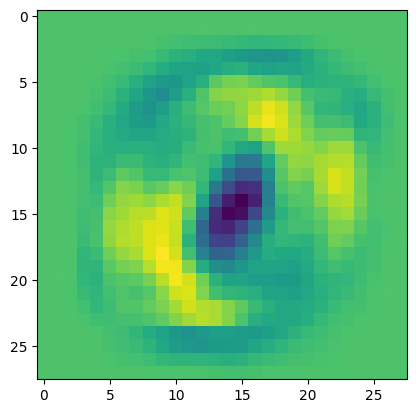

In [84]:
def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)  # For numerical stability
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def logisticRegressionMultiClassClassifierWithRegularization(Xtrain, ytrain, lambda_val, iterations=100, step_size=1e-4, verbose=False):
    n_classes = len(np.unique(ytrain))
    n_features = Xtrain.shape[1]
    A3 = np.zeros((n_features + 1, n_classes))  # Matrix to store weights for each class

    Xtrain_transformed = np.column_stack((Xtrain, np.ones((Xtrain.shape[0], 1))))  # Add bias term

    for class_index in range(n_classes):
        # Initialize weights for this class
        ytrain_binary = (ytrain == class_index).astype(int)  # Binary labels for one-vs-rest
        
        #print("Y train shape: ", ytrain_binary.shape )
        #a = np.zeros(n_features + 1)

        for i in range(iterations):
           scores = np.dot(Xtrain_transformed, A3)
           predictions = softmax(scores)
           #print("prediction shape: ", predictions.shape )
           prob_vector = predictions[:, class_index]
           gradient = -np.dot(Xtrain_transformed.T[:-1], (prob_vector-ytrain_binary))
           lambda_val= 10
           reg_term = 2* lambda_val * A3[:-1,class_index]
           gradient += reg_term
           #print(gradient.shape)
           bias_gradient = np.sum(prob_vector-ytrain_binary)
           # Update weights and bias separately
           A3[:-1, class_index] += step_size * gradient
           A3[-1, class_index] += step_size * bias_gradient   
           epsilon = 1e-6
           if verbose and i % 50 == 0:
                cost = -np.mean(ytrain_binary * np.log(prob_vector+epsilon) + (1 - ytrain_binary) * np.log(1 - prob_vector+epsilon))  + (lambda_val) * np.sum(A3[:-1, class_index] ** 2)
                #print(f"Iteration {i}, Cost: {cost}")

    return A3
    #YOUR CODE HERE
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionMultiClassClassifierWithRegularization(Xtrain, ytrain, lambda_val = 50, iterations=100, step_size=1e-4, verbose=True)
plt.imshow(np.reshape(a[0:-1,0],(28,28)))

# print(X_train.shape)
train = testLinearMCClassifier(a,X_train,y_train)
val = testLinearMCClassifier(a,X_val,y_val)
test = testLinearMCClassifier(a,X_test,y_test)

print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))


Best lambda: 0.01 with validation accuracy: 951
Mis-classifications= 6695 out of  49000  equivalent to  13.66326530612245%
Mis-classifications= 944 out of  7000  equivalent to  13.485714285714286%
Mis-classifications= 1963 out of  14000  equivalent to  14.021428571428572%


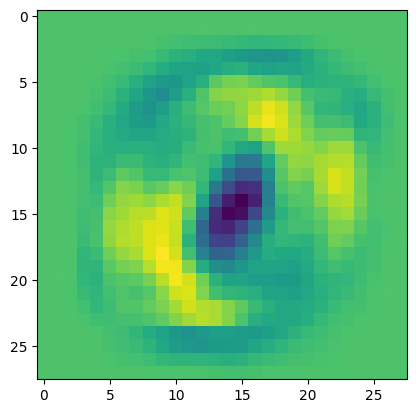

In [90]:

def Optimize_MC_Hyperparameters(Xtrain, ytrain,Xval, yval):
    best_lambda = None
    best_accuracy = 0
    A4 = None
    lambda_values = [0.01,0.1, 1 ,10,100]
    for lambda_val in lambda_values:
        # Train the model with the current lambda value
        A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lambda_val=lambda_val, iterations=100, step_size=1e-4, verbose=True)

        # Evaluate the model on the validation set
        accuracy = testLinearMCClassifier(A3,X_val, y_val)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lambda = lambda_val
            A4 = A3

    print(f"Best lambda: {best_lambda} with validation accuracy: {best_accuracy}")
    return A4

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
#a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=10)
best_lam = Optimize_MC_Hyperparameters(X_train, y_train,X_val,y_val)
a = logisticRegressionMultiClassClassifierWithRegularization(Xtrain, ytrain, best_lam, iterations=100, step_size=1e-4, verbose=True)
plt.imshow(np.reshape(a[0:-1,0],(28,28)))

# print(X_train.shape)
train = testLinearMCClassifier(a,X_train,y_train)
val = testLinearMCClassifier(a,X_val,y_val)
test = testLinearMCClassifier(a,X_test,y_test)

print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(train, int(X_train.shape[0]),train*100 / int(X_train.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(val, int(X_val.shape[0]),val*100 / int(X_val.shape[0])))
print("Mis-classifications= {} out of  {}  equivalent to  {}%".format(test, int(X_test.shape[0]),test*100 / int(X_test.shape[0])))




## Test the performance of a multiclass classifier

In [88]:
def testLinearMCClassifier(A,X_test, y_test):
    # Add a column of ones to X_test for the bias term
    X_test_augmented = np.column_stack((X_test, np.ones(X_test.shape[0])))

    class_scores = np.dot(X_test_augmented, A)


    # Predicted class is the one with the highest score
    predictions = np.argmax(class_scores, axis=1)

    # Count how many predictions are incorrect
    misclassified = np.sum(predictions != y_test)

    return misclassified


# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [89]:


# Train each algorithm
A1 = gaussianMultiChannelClassifier(X_train, y_train
A2 = logisticRegressionMultiClassClassifier(X_train, y_train)
lambda_val = 1.0  # Example lambda value
A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lambda_val)
lambda_values = [0.01,0.1, 1 ,10,100]
A4 = Optimize_MC_Hyperparameters(X_train, y_train,X_val,y_val)

# Evaluate each algorithm on the test dataset
misclassified_A1 = testLinearMCClassifier(A1,X_test, y_test)
misclassified_A2 = testLinearMCClassifier(A2,X_test, y_test)
misclassified_A3 = testLinearMCClassifier(A3,X_test, y_test)
misclassified_A4 = testLinearMCClassifier(A4,X_test, y_test)

# Report the results
print(f"Number of misclassifications (Gaussian Multi-Channel Classifier): {misclassified_A1}")
print(f"Number of misclassifications (Logistic Regression Multi-Class Classifier): {misclassified_A2}")
print(f"Number of misclassifications (Regularized Logistic Regression Multi-Class Classifier): {misclassified_A3}")
print(f"Number of misclassifications (Optimized Regularized Logistic Regression Multi-Class Classifier): {misclassified_A4}")




Training Logistic Regression Multi-Class Classifier
Best lambda: 0.01 with validation accuracy: 951
Number of misclassifications (Gaussian Multi-Channel Classifier): 2634
Number of misclassifications (Logistic Regression Multi-Class Classifier): 1808
Number of misclassifications (Regularized Logistic Regression Multi-Class Classifier): 1965
Number of misclassifications (Optimized Regularized Logistic Regression Multi-Class Classifier): 1965


Gaussian Multi-Channel Classifier, which likely uses a Gaussian distribution assumption for each class, misclassified 2634 samples. Logistic Regression Multi-Class Classifier misclassified 1808 samples. It performs better than the Gaussian Multi-Channel Classifier, indicating a better fit for the data or more effective handling of the class distinctions.  With regularization applied, this model misclassified 1965 samples. Interestingly, it does not perform as well as the standard logistic regression, suggesting that the regularization might not appropriately tuned for this dataset.The opimization process might not have significantly improved the model's performance since the misclassificaition is 1965, which is equal to the Regularized Logistic Regression Multi-Class Classifier with lambda = 1.